# Idea

Find times of the quarter with big movements in price and watch the drift of the asset for several periods after. Trade based on that (either hypothesizing momentum or reversal).

Example signal: long or short assets for days or a couple of weeks right after earnings according to size and direction of 1-day, post-event returns (similar to "post-earnings announcement drift").

# Imports

In [1]:
import pandas as pd

from binance.client import Client as bnb_client
from datetime import datetime

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    get_strategy_stats,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


In [4]:
# Split into train and test data
ret = px / px.shift() - 1

t = datetime(2024, 1, 1, 0, 0)
ret_train_data, ret_test_data = get_train_test_data(ret, t)
px_train_data, px_test_data = get_train_test_data(px, t)

# Look at returns over different periods in train data: 4h, 8h, 12h, 1d, 2d
# Try following trend for unusual coins

In [5]:
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 04:00:00,0.010716,0.013315,0.021739,0.020863,0.017069,NaN,NaN,0.033748,0.084668,NaN,...,NaN,0.004230,NaN,NaN,NaN,-0.006019,NaN,0.014607,NaN,NaN
2020-12-20 08:00:00,-0.002319,-0.003587,-0.010518,0.034671,0.000553,NaN,NaN,-0.026463,0.028529,NaN,...,NaN,0.010738,NaN,NaN,NaN,0.000000,NaN,0.007803,NaN,NaN
2020-12-20 12:00:00,0.014070,0.000551,0.004799,0.005433,-0.002589,NaN,NaN,0.008553,0.032914,NaN,...,NaN,-0.013320,NaN,NaN,NaN,0.022608,NaN,0.019803,NaN,NaN
2020-12-20 16:00:00,0.002172,-0.005235,-0.002418,-0.008791,-0.008512,NaN,NaN,-0.020991,-0.011406,NaN,...,NaN,-0.005466,NaN,NaN,NaN,-0.011844,NaN,-0.027506,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,0.000563,-0.005439,-0.003769,-0.002863,-0.000178,0.007924,NaN,-0.003526,-0.005505,-0.002136,...,-0.069320,0.000000,0.003623,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000
2025-08-30 20:00:00,-0.003231,0.005161,0.002685,0.006840,0.004346,-0.011268,NaN,0.004899,0.020111,0.004709,...,0.000000,0.000000,-0.087846,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000
2025-08-31 00:00:00,0.005397,0.025655,0.017281,0.001009,0.011492,0.024914,NaN,0.008125,-0.002894,0.018321,...,0.053793,0.000000,0.003298,0.022676,0.0,0.000000,0.037928,NaN,NaN,0.056136


In [103]:
four_week_means = ret_train_data.rolling(6 * 7 * 4, min_periods= 6 * 7).mean()
four_week_std = ret_train_data.rolling(6 * 7 * 4, min_periods = 6 * 7).std()

z_scores = (ret_train_data - four_week_means) / four_week_std

filtered_z_scores = z_scores[z_scores.abs() >= 2.50]
raw_signal = filtered_z_scores.ffill(limit = 6 * 7 * 2)

In [104]:
normalized_signal = get_rank_demeaned_normalized_signal(-1 * raw_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(normalized_signal, px_train_data)

<Axes: xlabel='open_time'>

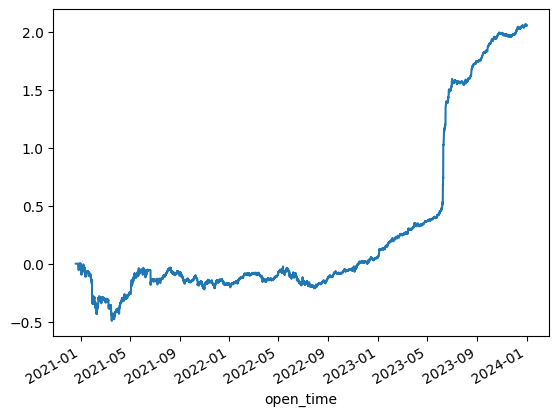

In [105]:
gross_returns.cumsum().plot()

<Axes: xlabel='open_time'>

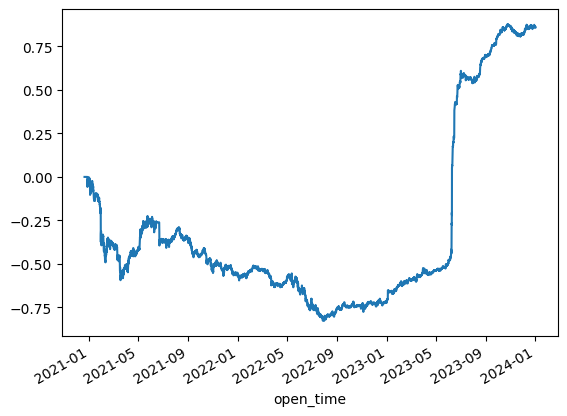

In [106]:
net_returns.cumsum().plot()

In [114]:
pd.Series(get_strategy_stats(net_returns, 4, px_train_data), name="Strat").to_frame()

,Strat
avg returns,0.283355
decorrelated avg returns,0.293152
volatility,0.329304
sharpe ratio,0.860465
decorrelated sharpe ratio,0.891146
max drawdown,-0.117299
max drawdown duration,894.666667
alpha_BTC,0.000134
beta_BTC,-0.023505


In [65]:
normalized_daily_signal = normalized_signal[normalized_signal.index.hour == 0]
px_daily_train_data = px_train_data[px_train_data.index.hour == 0]

gross_daily_returns, net_daily_returns = get_gross_returns_and_net_returns(
    normalized_daily_signal, px_daily_train_data)

<Axes: xlabel='open_time'>

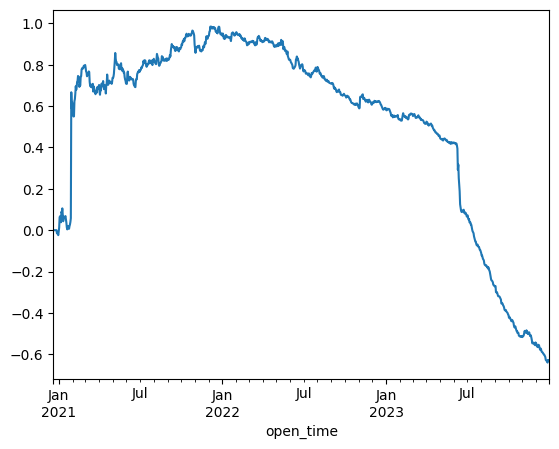

In [66]:
gross_daily_returns.cumsum().plot()

<Axes: xlabel='open_time'>

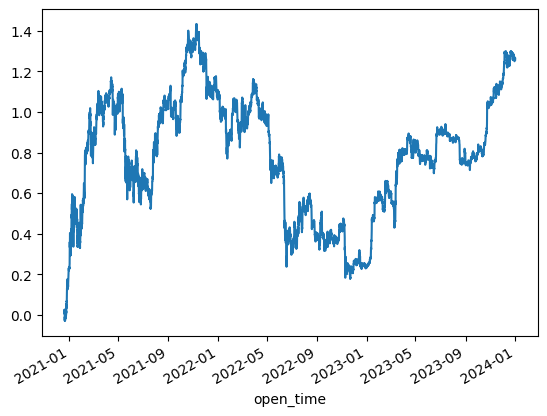

In [56]:
(px_train_data['BTCUSDT'] / px_train_data['BTCUSDT'].shift() - 1).cumsum().plot()

In [100]:
avg_z_score = z_scores.rolling(7).mean()
filtered_avg_z_scores = avg_z_score[avg_z_score.abs() >= 0.8]

filtered_avg_z_scores
raw_signal = filtered_avg_z_scores.ffill(limit = 7)
raw_signal

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.826842,NaN,...,NaN,-0.902319,0.823013,NaN,NaN,NaN,-0.943109,NaN,NaN,NaN
2023-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.826842,NaN,...,NaN,NaN,0.823013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.826842,NaN,...,NaN,NaN,0.823013,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='open_time'>

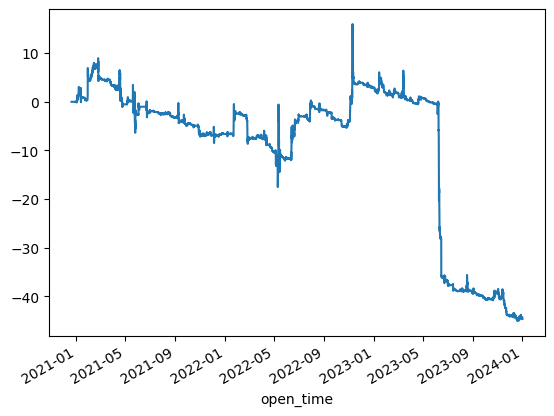

In [102]:
gross_returns, net_returns = get_gross_returns_and_net_returns(raw_signal, px_train_data)

gross_returns.cumsum().plot()

# Fetching News Data

In [5]:
# from polygon import RESTClient
# from polygon.rest.models import (
#     TickerNews,
# )

# client = RESTClient("Z18nRpCOazbM35uu5cazvg25oTp1XS25")

# news = []
# for n in client.list_ticker_news(
#     ticker="GM",
#     published_utc_lte="2025-10-01",
#     order="asc",
#     limit="4",
#     sort="published_utc",
# ):
#     news.append(n)

# #print(news)

# # print date + title
# for index, item in enumerate(news):
#     # verify this is an agg
#     if isinstance(item, TickerNews):
#         print("{:<25}{:<15}".format(item.published_utc, item.title))
        
#         if index == 20:
#             break

MaxRetryError: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/reference/news?cursor=YXA9MjAyMS0wNC0yN1QxNiUzQTAzJTNBMDBaJmFzPVk4VzlsekRQX3pXTkNtZTZGd19VZzNrOGU4cXd3T2hfcGIwSnl2c0J4WWMmbGltaXQ9NCZvcmRlcj1hc2NlbmRpbmcmcHVibGlzaGVkX3V0Yy5sdGU9MjAyNS0xMC0wMSZ0aWNrZXI9R00 (Caused by ResponseError('too many 429 error responses'))

In [ ]:
# client = RESTClient(api_key="Z18nRpCOazbM35uu5cazvg25oTp1XS25")
# trades = [t for t in client.list_trades(ticker="TSLA", limit=100)]

In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # Step 1: Define the URL of the website to scrape
# # url = 'http://www.webscraper-testsite.com/news/'
# url = 'https://www.cnn.com/'

# # Step 2: Send a GET request to the website
# try:
#     response = requests.get(url)
#     # Raise an exception for bad status codes (4xx or 5xx)
#     response.raise_for_status()
    
#     print(response.text)

#     # Step 3: Parse the HTML content using Beautiful Soup
#     soup = BeautifulSoup(response.text, 'html.parser')

#     # Step 4: Find and extract the data
#     # Inspect the website's HTML to find the correct tags and classes
#     # For this site, headlines are within <h2> tags with class 'story-headline'
#     headlines = soup.find_all('h2', class_='story-headline')

#     # Step 5: Print the extracted data
#     if headlines:
#         print("Latest News Headlines:")
#         for index, headline in enumerate(headlines, 1):
#             print(f"{index}. {headline.text.strip()}")
#     else:
#         print("No headlines found.")

# except requests.exceptions.RequestException as e:
#     print(f"Error fetching the URL: {e}")